**Primer acercamiento a redes siamesas utilizando Pytorch**

En tareas de aprendizaje profundo, las redes siamesas han emergido como una arquitectura poderosa para resolver problemas de comparación y similitud entre dos entradas, como imágenes, texto o señales.

Se basan en la idea de entrenar dos redes gemelas que comparten pesos para
comparar pares de imágenes. Este método ha demostrado
ser eficaz en la verificación de firmas y otros problemas de
coincidencia de imágenes. La función de pérdida utilizada
en las redes siamesas, conocida como **Contrastive Loss**,
busca minimizar la distancia entre las representaciones de
imágenes similares y maximizarla entre las representacio-
nes de imágenes diferentes.

<center><img src = https://tse2.mm.bing.net/th?id=OIP.2VBBzdfjYsY0s_lPs4l3BgHaEG&rs=1&pid=ImgDetMain height = '250'></center>

Para hacer un primer enfoque al problema en este cuaderno se proponet tratar con el más sencillo de los datasets y más comunmente usado MNIST. Se describe a continuación los cambios necesarios para entrenar con el conjunto de datos y el proceso seguido en el aprendizaje.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision.transforms import ToPILImage

Aquí se define el conjunto de datos y los dataloaders. Los datos están diseñados para ser compatibles con el modelo siamesa, donde cada muestra incluye pares de imágenes y etiquetas que indican si las imágenes son similares o no. Ahora se aborda este problema en profundidad.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

subset_size = 1000
rest_size = len(train_dataset) - subset_size
train_dataset, rest = random_split(train_dataset, [subset_size, rest_size])
rest_size = len(test_dataset) - subset_size
test_dataset, rest = random_split(test_dataset, [subset_size, rest_size])

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.40MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.7MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Definimos funciones auxiliares que nos ayudarán a la visualización del problema.

In [ ]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

Vamos con la **creación del dataset**:

El diseño del dataset es esencial para entrenar redes siamesas, ya que:

* Genera dinámicamente pares de imágenes durante el entrenamiento, asegurando diversidad.
* Facilita que la red aprenda a diferenciar entre imágenes similares y no similares al presentar pares etiquetados explícitamente como "iguales" o "diferentes".
* Permite aplicar transformaciones consistentes a las imágenes para mejorar la generalización del modelo.

**Obtenemos así, que cuando llamemos a un dataloader, cada una de las muestras estará compuesta por un par de imágenes y una etiqueta, si pertencen o no a la misma clase las dos imágenes dadas.**

In [ ]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,dataset,transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self,index):
        img0, label0 = random.choice(self.dataset)

        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                img1, label1 = random.choice(self.dataset)
                if label0 == label1:
                    break
        else:

            while True:
                img1, label1 = random.choice(self.dataset)
                if label0 != label1:
                    break

        img0 = ToPILImage()(img0)
        img1 = ToPILImage()(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(label0 != label1)], dtype=np.float32))

    def __len__(self):
        return len(self.dataset)

In [ ]:
siamese_dataset = SiameseNetworkDataset(dataset=train_dataset,transform=transform)

Todo lo explicado con anterioridad lo podemos visualizar como sigue. Se muestra un batch de 8 imágenes concatenadas y con sus respectivas etiquetas:

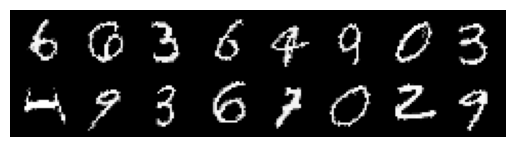

[1. 1. 0. 0. 1. 1. 1. 1.]


In [ ]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

example_batch = next(iter(vis_dataloader))
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

Estamos ahora en condiciones de crear nuestro modelo para el posterior entrenamiento. Para ello, se describe a continuación la arquitectura usada:

* `encoder`: es un modelo que toma una entrada (como una imagen) y la transforma en un vector de características (embedding). Este encoder se aplica a ambas entradas ($x_1$,$x_2$), y los pesos son compartidos para que las transformaciones sean consistentes.

* `head`: Una red adicional que toma como entrada la combinación de los embeddings y produce la salida final.

* `forward`: Obtiene los embeddings de las dos entradas ($x_1$,$x_2$) pasando ambas por el encoder. Luego, Combina los embeddings de ambas entradas concatenándolos a lo largo del eje de características. La concatenación permitirá al modelo aprender relaciones complejas entre los dos embeddings.

In [ ]:
class SiameseModel(nn.Module):
  def __init__(self, encoder):
    super(SiameseModel, self).__init__()
    encoder[0] = nn.Conv2d(1, 64, kernel_size=7,
                                   stride=2, padding=3, bias=False)
    self.encoder = encoder
    self.head = nn.Sequential(
          nn.Linear(512, 128)
      )

  def forward_once(self, x):

    output = self.encoder(x)
    output = output.view(output.size()[0], -1)
    output = self.head(output)
    return output

  def forward(self, input1, input2):
      output1 = self.forward_once(input1)
      output2 = self.forward_once(input2)

      return output1, output2

Vamos ahora con la **función de pérdida** a utilizar. La clase toma un argumento `m`, que representa un margen que separa los pares positivos y negativos. Las parejas distintas contribuyen a la función de pérdida solo si la distancia entre ellas está dentro del radio definido por `m`.

<center><img src = https://github.com/adambielski/siamese-triplet/blob/master/images/contrastive_loss.png?raw=true></center>

El resultado de la función forward es un valor escalar de pérdida que mide qué tan bien está desempeñándose el modelo en la tarea. La pérdida se calcula en función de qué tan cercana está la puntuación de similitud entre las entradas a la puntuación de similitud esperada (ground truth). Si la puntuación de similitud está cerca de la puntuación esperada, la pérdida será baja. Por el contrario, si la puntuación de similitud está lejos de la puntuación esperada, la pérdida será alta. La función de pérdida fomenta que el modelo aprenda representaciones de las entradas que capturen su similitud.

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

Usaremos una red ResNet preentrenada:

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True)
backbone = nn.Sequential(*list(resnet18.children())[:-2])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 83.6MB/s]


In [ ]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

net1 = SiameseModel(encoder = backbone)
criterion = ContrastiveLoss(margin = 0.2)
optimizer = optim.Adam(net1.parameters(), lr = 0.0005 )

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
print(len(train_dataset))

1000


Para el entrenamiento se sigue el esquema usual utilizado en PyTorch, con los objetos `criterion`, `optimizer` y `model` creados previamente:

Epoch number 0
 Current loss 1.0765504837036133

Epoch number 1
 Current loss 0.12586069107055664

Epoch number 2
 Current loss 0.0315932035446167

Epoch number 3
 Current loss 0.01252700388431549

Epoch number 4
 Current loss 0.015614673495292664

Epoch number 5
 Current loss 0.012866059318184853

Epoch number 6
 Current loss 0.012231185100972652

Epoch number 7
 Current loss 0.008363282307982445

Epoch number 8
 Current loss 0.01413474977016449

Epoch number 9
 Current loss 0.009117446839809418



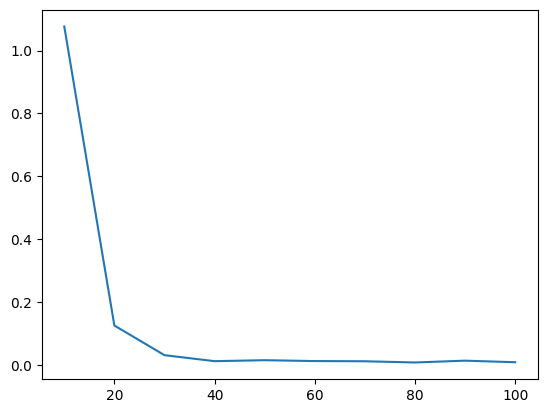

In [ ]:
counter = []
loss_history = []
iteration_number= 0

for epoch in range(10):

    for i, (img0, img1, label) in enumerate(train_dataloader):

        optimizer.zero_grad()

        output1, output2 = net1(img0, img1)

        loss_contrastive = criterion(output1, output2, label)

        loss_contrastive.backward()

        optimizer.step()

        if i % 1000 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

Para poner a prueba nuestro modelo, podemos usar la distancia euclídea entre los embeddings dados por la red, para ver si las instancias de la misma clase presentan una distancia menor que aquellas que son de la misma clase.

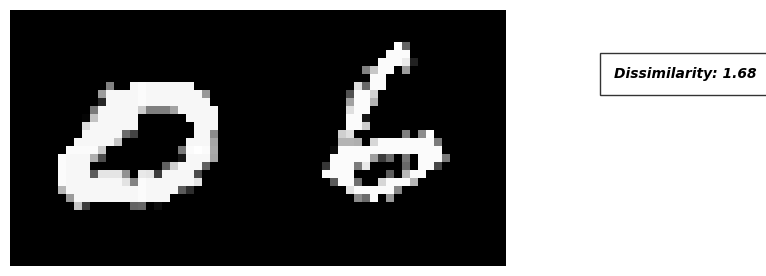

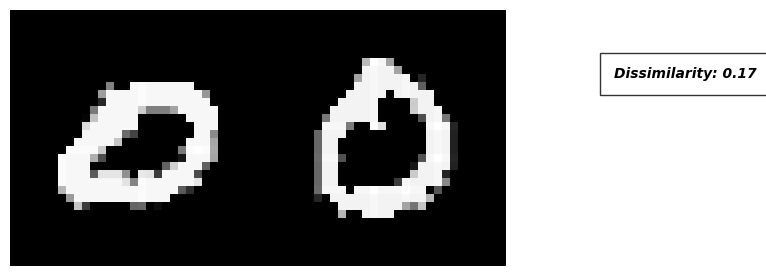

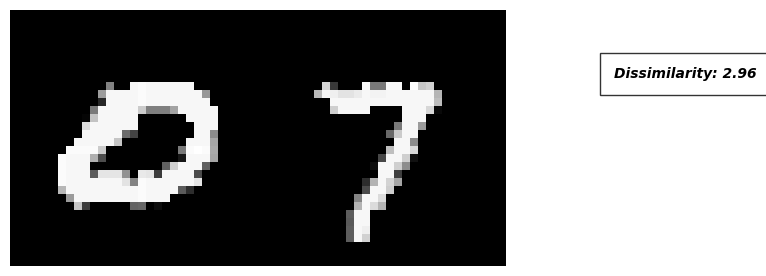

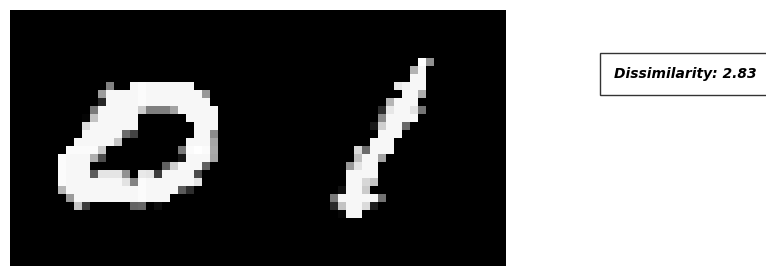

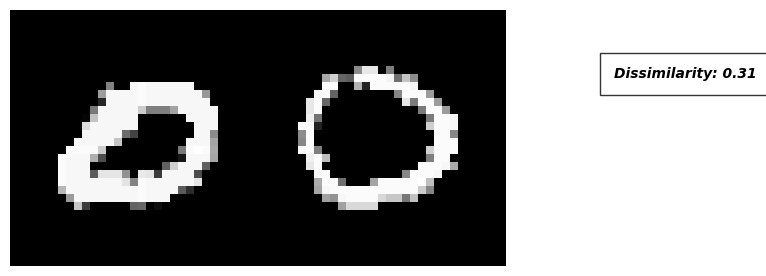

In [ ]:
test = SiameseNetworkDataset(dataset=test_dataset,transform=transform)
test_dataloader = DataLoader(test, num_workers=2, batch_size=1, shuffle=True)

dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)
net1.eval()

for i in range(5):
    # Iterate over 5 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)

    output1, output2 = net1(x0, x1)
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

Obtenemos resultados decentes, ha sido un buen primer acercamiento.

$$$$

**Redes con Triplet Loss**

El enfoque ahora es completamente análogo, la única diferencia es el uso de ancla, positivo y negativo, además de la función de pérdida.

La triplet loss se define utilizando tres componentes: un
ancla (anchor), un positivo (positive) y un negativo (nega-
tive). El ancla es una imagen de una persona específica, el positivo es otra imagen de la misma persona, y el negativo es una imagen de una persona diferente. **El objetivo del triplet loss es minimizar la distancia entre el ancla y el positivo, mientras que se maximiza la distancia entre el ancla y el negativo.**

$$$$

Creamos dataset:



In [ ]:
class SiameseNetworkDatasetTriplet(Dataset):

    def __init__(self, dataset, transform = None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):

        img1, label1 = random.choice(self.dataset)
        while True:
          img2, label2 = random.choice(self.dataset)
          if label1 == label2:
              break
        while True:
          img3, label3 = random.choice(self.dataset)
          if label1 != label3:
              break

        img1 = ToPILImage()(img1)
        img2 = ToPILImage()(img2)
        img3 = ToPILImage()(img3)
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)
        return (img1, img2, img3)

    def __len__(self):
        return len(self.dataset)

In [ ]:
siamese_dataset2 = SiameseNetworkDatasetTriplet(dataset=train_dataset,transform=transform)

Visualizamos como hacíamos antes:

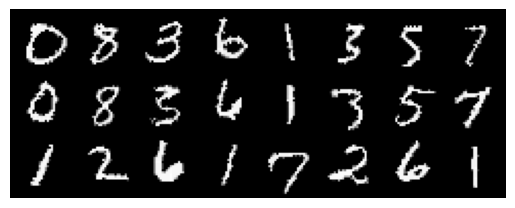

In [ ]:
vis_dataloader = DataLoader(siamese_dataset2,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

example_batch = next(iter(vis_dataloader))

concatenated = torch.cat((example_batch[0], example_batch[1], example_batch[2]),0)

imshow(torchvision.utils.make_grid(concatenated))

In [ ]:
class SiameseModelTriplet(nn.Module):
  def __init__(self, encoder):
    super(SiameseModelTriplet, self).__init__()
    encoder[0] = nn.Conv2d(1, 64, kernel_size=7,
                                   stride=2, padding=3, bias=False)
    self.encoder = encoder
    self.head = nn.Sequential(
          nn.Linear(512, 2)
      )

  def forward_once(self, x):
    output = self.encoder(x)
    output = output.view(output.size()[0], -1)
    output = self.head(output)
    return output

  def forward(self, input1, input2, input3):
      output1 = self.forward_once(input1)
      output2 = self.forward_once(input2)
      output3 = self.forward_once(input3)

      return output1, output2, output3

Ahora se define la función de pérdida mencionada. Se pretende que se cumpla la condición:

$$\|f(x_a)-f(x_p)\|^2+\alpha<\|f(x_a)-f(x_n)\|^2$$

In [ ]:
class TripletLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
      distance_positive = torch.pow(anchor - positive, 2)
      distance_negative = torch.pow(anchor - negative, 2)
      losses = F.relu(distance_positive - distance_negative + self.margin)
      return torch.mean(losses)

In [ ]:
train_dataloader = DataLoader(siamese_dataset2,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

net2 = SiameseModelTriplet(encoder = backbone)
criterion = TripletLoss(margin = 0.2)
optimizer = optim.Adam(net2.parameters(), lr = 0.0005 )

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


El proceso de entrenamiento es totalmente análogo, solo que ahora debemos hacer **forward pass de las tres imágenes**. Combinando esto con la función de pérdida tenemos un entrenamiento exitoso:

Epoch number 0
 Current loss 0.2379235476255417

Epoch number 1
 Current loss 0.16041038930416107

Epoch number 2
 Current loss 0.13062605261802673

Epoch number 3
 Current loss 0.08309897035360336

Epoch number 4
 Current loss 0.18198943138122559

Epoch number 5
 Current loss 0.08820419013500214

Epoch number 6
 Current loss 0.08343187719583511

Epoch number 7
 Current loss 0.05441824346780777

Epoch number 8
 Current loss 0.037676915526390076

Epoch number 9
 Current loss 0.031146155670285225



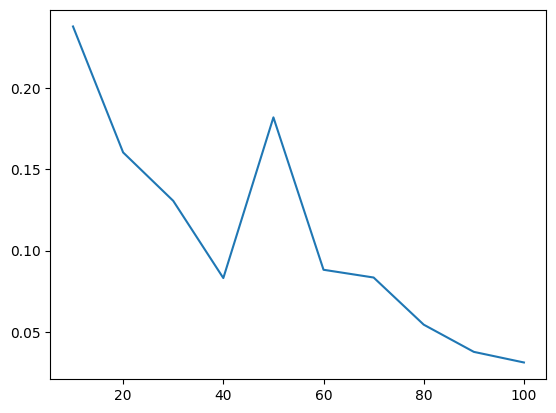

In [ ]:
counter = []
triplet_history = []
iteration_number= 0

for epoch in range(10):

    for i, (img0, img1, img2) in enumerate(train_dataloader):

        optimizer.zero_grad()

        output1, output2, output3 = net2(img0, img1, img2)

        triplet_loss = criterion(output1, output2, output3)

        triplet_loss.backward()

        optimizer.step()

        if i % 1000 == 0 :
            print(f"Epoch number {epoch}\n Current loss {triplet_loss.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            triplet_history.append(triplet_loss.item())

show_plot(counter, triplet_history)

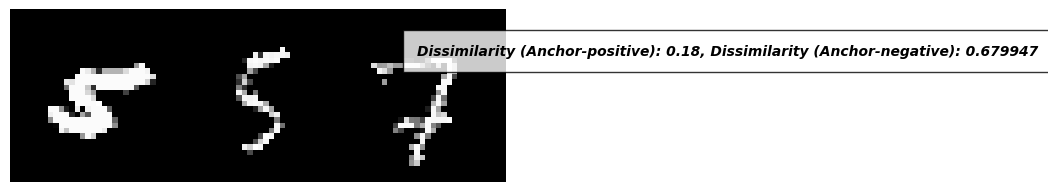

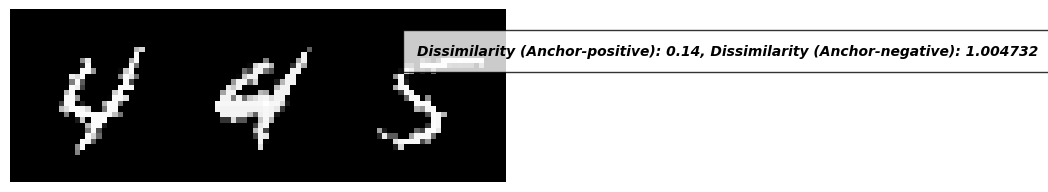

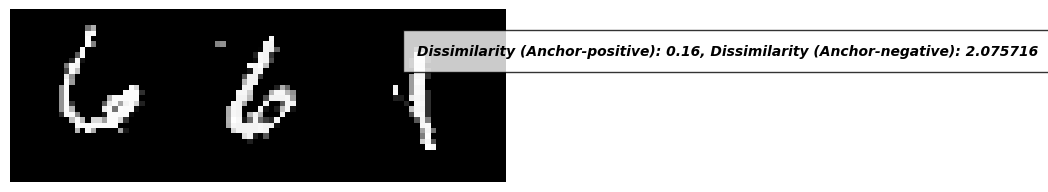

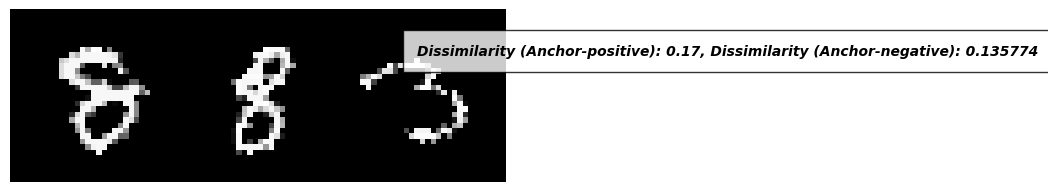

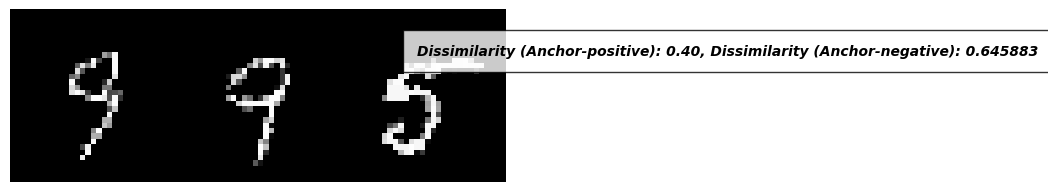

In [ ]:
test = SiameseNetworkDatasetTriplet(dataset=test_dataset,transform=transform)
test_dataloader = DataLoader(test, num_workers=2, batch_size=1, shuffle=True)

dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)
net2.eval()

for i in range(5):

    x0, x1, x2 = next(dataiter)
    concatenated = torch.cat((x0, x1, x2))

    output1, output2, output3 = net2(x0, x1, x2)
    euclidean_distance1 = F.pairwise_distance(output1, output2)
    euclidean_distance2 = F.pairwise_distance(output1, output3)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity (Anchor-positive): {euclidean_distance1.item():.2f}, Dissimilarity (Anchor-negative): {euclidean_distance2.item():-2f}')

In [ ]:
net1.eval()
net2.eval()

embeddings_contrastive = []
embeddings_triplet = []
labels = []

test_loader = DataLoader(test_dataset, num_workers=2, batch_size=1, shuffle=True)

with torch.no_grad():
    for images, target in test_loader:

        labels.extend(target.numpy())

        emb_contrastive = net1.forward_once(images).cpu().numpy()
        emb_triplet = net2.forward_once(images).cpu().numpy()

        embeddings_contrastive.append(emb_contrastive)
        embeddings_triplet.append(emb_triplet)

embeddings_contrastive = np.vstack(embeddings_contrastive)
embeddings_triplet = np.vstack(embeddings_triplet)
labels = np.array(labels)

Por último, podemos visualizar cómo quedan distribuidos los emevbeddings calculados y predichos por la red. Para ello, hacemos uso de técnicas de **reducción de dimensionalidad**, como puede ser `T-SNE`. Tan sencillo como llamar a la función de sklearn y visualizar lo obtenido, distinguiendo las clases por colores. Lo hacemos para la Contrastive Loss y para la Triplet también.

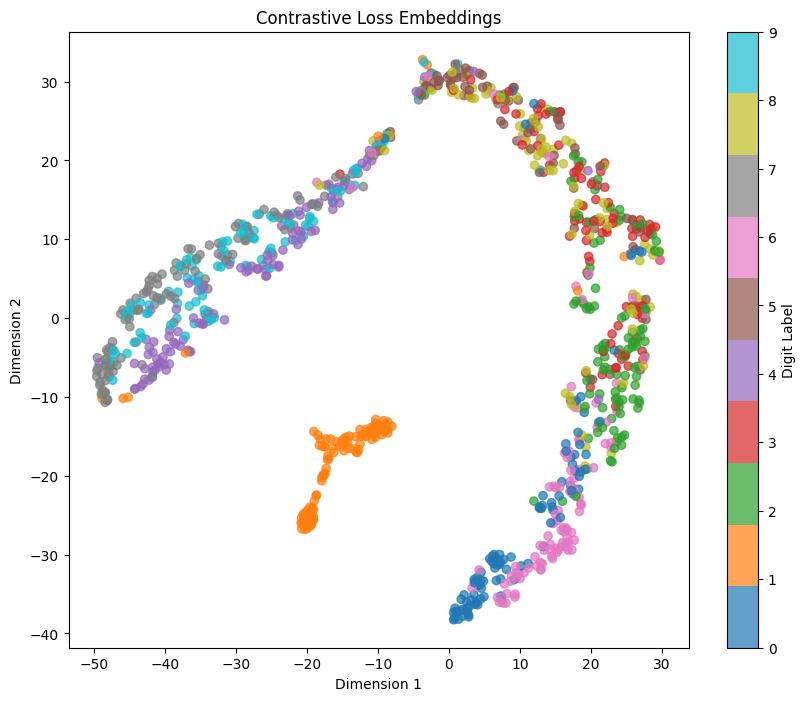

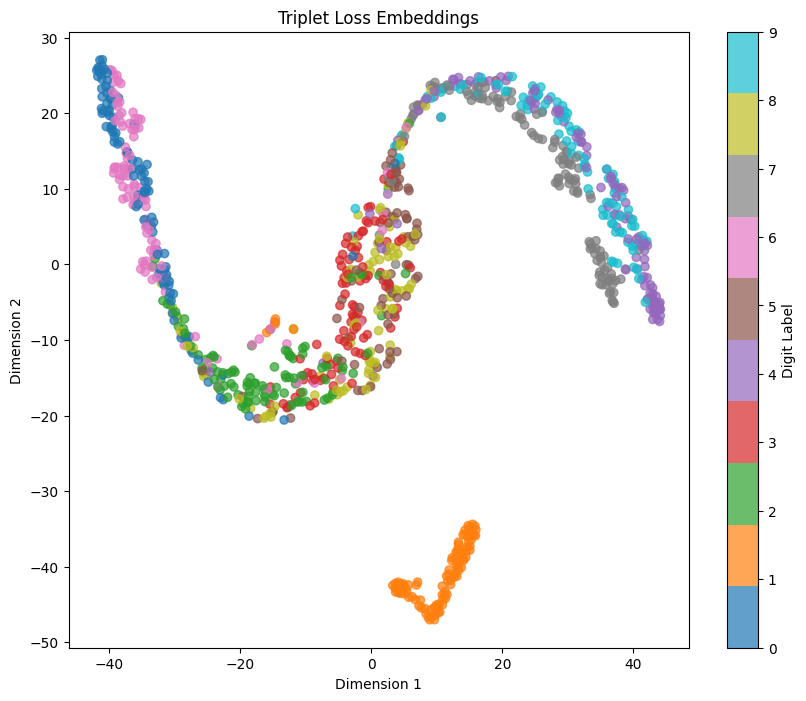

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne_contrastive = TSNE(n_components=2, random_state=42)
embeddings_2d_contrastive = tsne_contrastive.fit_transform(embeddings_contrastive)

tsne_triplet = TSNE(n_components=2, random_state=42)
embeddings_2d_triplet = tsne_triplet.fit_transform(embeddings_triplet)

def plot_embeddings(embeddings, labels, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label='Digit Label')
    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

plot_embeddings(embeddings_2d_contrastive, labels, "Contrastive Loss Embeddings")
plot_embeddings(embeddings_2d_triplet, labels, "Triplet Loss Embeddings")

El enfoque y experimento que sigue ahora es prácticamente igual. Solo se hace un breve acercamiento a la minería negativa semi-dura propuesta en el trabajo. En el notebook con experimentos con lfwPairs se hace especial hincapié en esto. Repetimos todo el proceso anterior pero con esta pequeña modificación.

El objetivo de este experimento es comprobar que, efectivamente, es una técnica que da resultados.

In [ ]:
class SiameseDataset(Dataset):
    def __init__(self, dataset, num_samples_per_identity=40, transform=None):
        self.dataset = dataset
        self.num_samples_per_identity = num_samples_per_identity
        self.transform = transform

        # Crear un diccionario de etiquetas a imágenes
        self.label_to_indices = {}
        for idx, (_, label) in enumerate(self.dataset):
            if label not in self.label_to_indices:
                self.label_to_indices[label] = []
            self.label_to_indices[label].append(idx)

    def __getitem__(self, index):
        img, label = self.dataset[index]

        if self.transform:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.dataset)

In [ ]:
def select_triplets_online(embeddings, labels, margin):
    pairwise_distances = torch.cdist(embeddings, embeddings, p=0.2)
    triplets = []

    for i in range(len(embeddings)):
        anchor_label = labels[i]
        positive_indices = torch.where(labels == anchor_label)[0]
        negative_indices = torch.where(labels != anchor_label)[0]

        for pos_idx in positive_indices:
            if i == pos_idx:
                continue  # Saltar el caso del mismo índice

            ap_distance = pairwise_distances[i, pos_idx].item()

            # Filtrar los negativos que cumplan la restricción
            valid_negatives = []
            for neg_idx in negative_indices:
                an_distance = pairwise_distances[i, neg_idx].item()
                if ap_distance < an_distance < ap_distance + margin:
                    valid_negatives.append(neg_idx)

            # Seleccionar el hard negative (distancia mínima entre los válidos)
            if valid_negatives:
                hard_negative = valid_negatives[
                    torch.argmin(pairwise_distances[i, valid_negatives])
                ]
                triplets.append((i, pos_idx.item(), hard_negative.item()))

    return triplets

In [ ]:
class SiameseModelFinal(nn.Module):
  def __init__(self, encoder):
    super(SiameseModelFinal, self).__init__()
    encoder[0] = nn.Conv2d(1, 64, kernel_size=7,
                                   stride=2, padding=3, bias=False)
    self.encoder = encoder
    self.head = nn.Sequential(
          nn.Linear(512, 128)
      )

  def forward(self, x):
    output = self.encoder(x)
    output = output.view(output.size()[0], -1)
    output = self.head(output)
    return output

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):

        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):

        positive_distance = torch.norm(anchor - positive, p=2, dim=1)  # ||f(x_a) - f(x_p)||
        negative_distance = torch.norm(anchor - negative, p=2, dim=1)  # ||f(x_a) - f(x_n)||

        losses = torch.relu(positive_distance - negative_distance + self.margin)  # max(0, d_ap - d_an + margin)

        return losses.mean()

In [ ]:
train_dataloader = DataLoader(train_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

net3 = SiameseModelFinal(encoder = backbone)
criterion = TripletLoss()
optimizer = optim.Adam(net3.parameters(), lr = 0.0005 )

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
counter = []
triplet_history = []
iteration_number= 0

for epoch in range(10):
  epoch_loss = 0

  for images, labels in train_dataloader:
    images, labels = images, labels

    triplets = select_triplets_online(net3(images), labels, 0.2)

    anchor_indices, positive_indices, negative_indices = zip(*triplets)

    a_embeddings = net3.forward(images[list(anchor_indices)])
    p_embeddings = net3.forward(images[list(positive_indices)])
    n_embeddings = net3.forward(images[list(negative_indices)])

    loss = criterion(a_embeddings, p_embeddings, n_embeddings)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  print(f"Epoch [{epoch+1}/{10}], Loss: {epoch_loss/len(train_dataloader):.4f}")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/10], Loss: 0.7282
Epoch [2/10], Loss: 0.9093
Epoch [3/10], Loss: 0.5700
Epoch [4/10], Loss: 0.4602
Epoch [5/10], Loss: 0.7036
Epoch [6/10], Loss: 0.3441
Epoch [7/10], Loss: 0.3128
Epoch [8/10], Loss: 0.4255
Epoch [9/10], Loss: 0.2925
Epoch [10/10], Loss: 0.1860


In [ ]:
net3.eval()

embeddings_triplet = []
labels = []

test_loader = DataLoader(test_dataset, num_workers=2, batch_size=1, shuffle=True)

with torch.no_grad():
    for images, target in test_loader:

        labels.extend(target.numpy())
        emb_triplet = net3.forward(images).cpu().numpy()
        embeddings_triplet.append(emb_triplet)

embeddings_triplet = np.vstack(embeddings_triplet)
labels = np.array(labels)

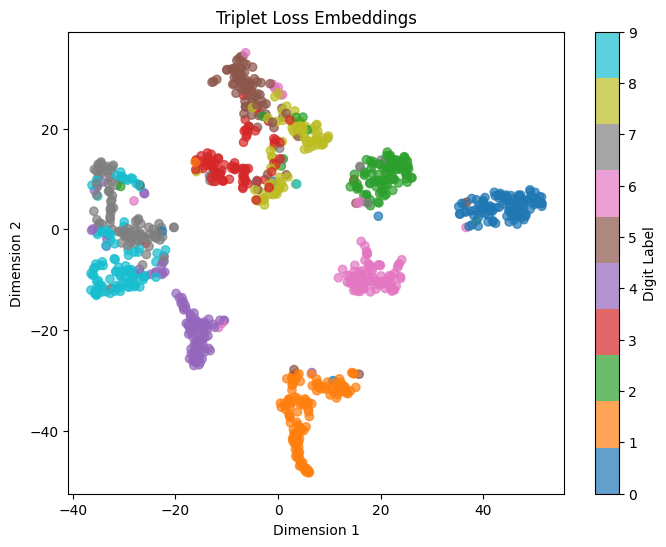

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne_triplet = TSNE(n_components=2, random_state=42)
embeddings_2d_triplet = tsne_triplet.fit_transform(embeddings_triplet)

def plot_embeddings(embeddings, labels, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label='Digit Label')
    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

plot_embeddings(embeddings_2d_triplet, labels, "Triplet Loss Embeddings")